# Bayesian optimization

The Bayesian optimization (BO) allow optimization of black-box objective function $f$ with expensive sampling.
The samples of function $f$ read $D_{i-1} = [(\bm{x}_1, y_1), (\bm{x}_2, y_2), ... (\bm{x}_{i-1}, y_{i-1})]$
The BO procedure is as follows:
For $i = 1, 2, ...$ do

1) Find the next sampling point $x_i$ by optimizing te aquisition function $u$
$
\bm{x}_i = \text{argmax}_{\bm{x}} u(\bm{x} | D_{i-1})
$

2) Make sample of the objective function $y_i = f(\bm{x}_i) + \epsilon_i$ with possible noise $\epsilon_i$

3) Add the new sample to the previous samples $D_i = [D_{i+1}, (\bm{x}_i, y_i)]$ and update the surrogate GP model. 


### Aquisition functions 



In [1]:
import numpy as np 
from scipy.stats import norm 
from scipy.optimize import minimize 

import matplotlib.pyplot as plt 
from ipywidgets import interactive

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern 

In [2]:
def objfunc(x: np.ndarray, noise: float=0.2):
    return 0.7  * x + np.sin(x) + noise * np.random.randn(*x.shape)

kernel = ConstantKernel(1.0) + Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.01)


In [82]:
def expected_improvement(X, X_sampled, Y_sampled, gpr, xi=0.01):
    """
    Expected improvement aquisition function.
    
    Args:
        X: (np.ndarray) point where to calculate the EI 
        X_sampled: (np.ndarray)
        Y_sampled: (np.ndarray) 
        gpr      : (GaussianProcessRegressor) surrogate model
        xi       : (float)
    Returns:
        (float) expected improvement in the point x
    """
    
    mu, sigma = gpr.predict(X.reshape(-1, 1), return_std=True)
    mu_sample = gpr.predict(X_sampled.reshape(-1, 1))
    
    def calc_ei(mu, sigma):
        if sigma != 0:
            mu_sample_max = np.max(mu_sample)
            imp = mu - mu_sample_max - xi  # improvement
            Z = imp / sigma
            ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        else: 
            ei = 0 
        return ei.flatten()
    
    ei = np.vectorize(calc_ei)(mu.flatten(), sigma.flatten())
    return ei

def propose_next_sampling(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    """ 
    
    """ 
    n_features = X_sample.shape[1]
    f_min  = 1
    x_next = None
    def obj(x): return -acquisition(x, X_sample, Y_sample, gpr)

    
    # make initial guesses
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, n_features)):
        
        res = minimize(obj, x0=x0, bounds=bounds)
        if res.fun < f_min:
            f_min  = res.fun[0]
            x_next = res.x 

    return x_next.reshape(-1, 1)
    


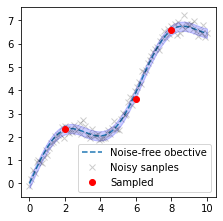

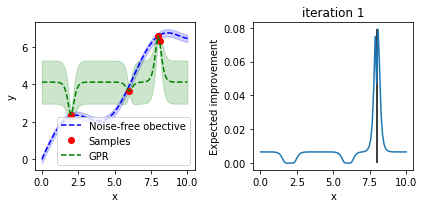

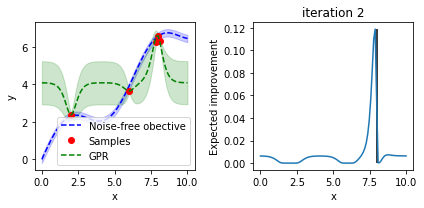

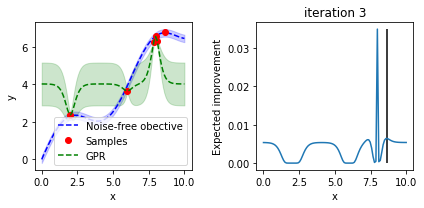

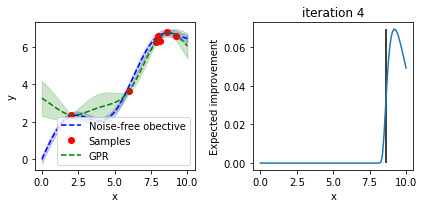

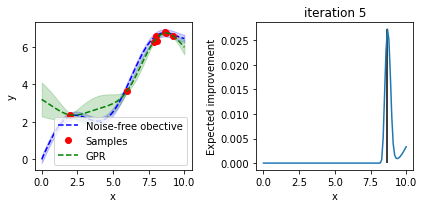

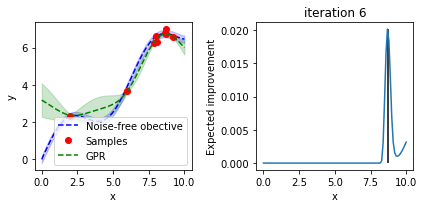

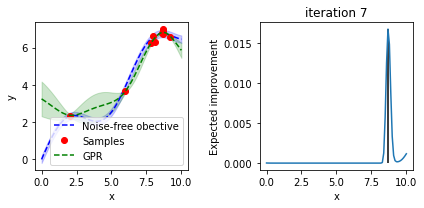

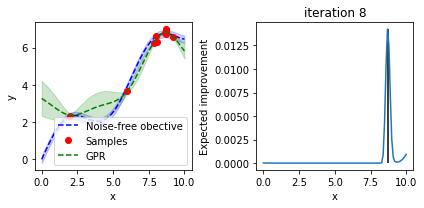

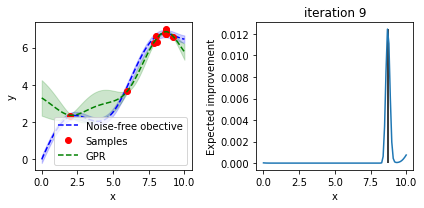

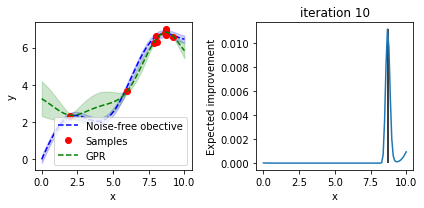

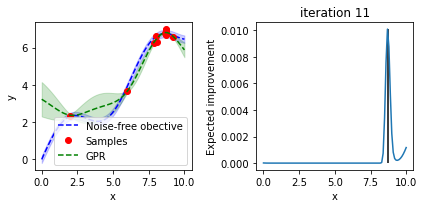

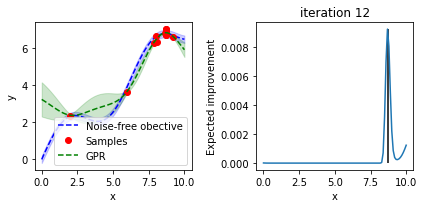

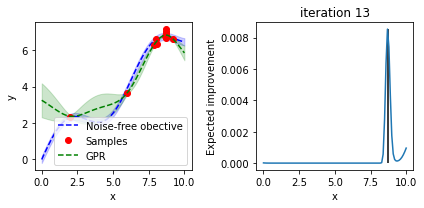

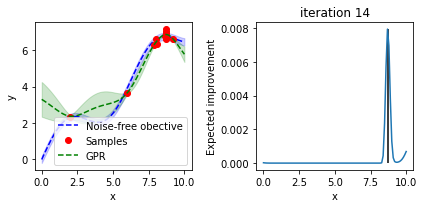

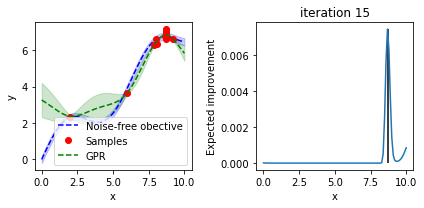

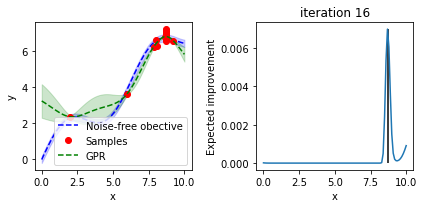

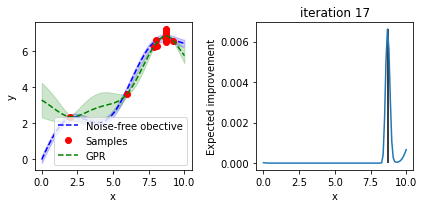

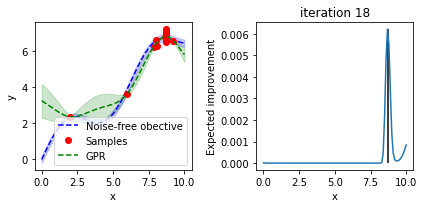

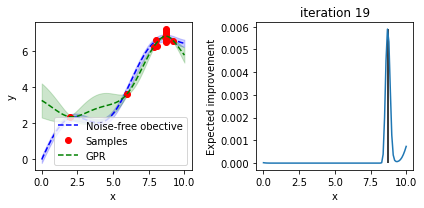

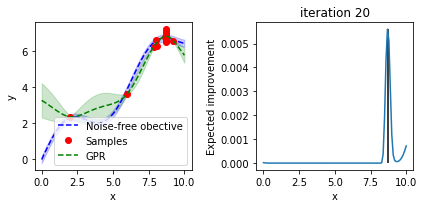

In [87]:
n_iters = 20
bounds  = np.array([[0, 10]])
X = np.linspace(bounds[:,0], bounds[:, 1], 100).reshape(-1, 1)
X_sampled = np.array([[2], [6], [8]])
Y_sampled = objfunc(X_sampled, 0.2)
n_init_samples = len(X_sampled)
Y_max = []

fig, ax = plt.subplots(figsize=(3.5, 3.5))

plt.plot(X, objfunc(X, 0.0), '--', label='Noise-free obective')
plt.plot(X, objfunc(X, 0.2), 'kx', alpha=0.2, label='Noisy sanples')
plt.plot(X_sampled, Y_sampled, 'ro', label='Sampled')
plt.fill_between(X.flatten(), objfunc(X, 0).flatten() - 0.2, objfunc(X, 0).flatten() + 0.2, alpha=0.2, color='blue')
plt.legend()
plt.show()

for i in range(n_iters):
    gpr.fit(X_sampled.reshape(-1, 1), Y_sampled.reshape(-1, 1))
    mu_test, sigma_test = gpr.predict(X.reshape(-1, 1) ,return_std=True)

    x_next = propose_next_sampling(expected_improvement, X_sampled, Y_sampled, gpr, bounds)
    y_next = objfunc(x_next)

    X_sampled = np.vstack((X_sampled, x_next))
    Y_sampled = np.vstack((Y_sampled, y_next))
    ei = expected_improvement(X, X_sampled, Y_sampled, gpr)

    y_max = np.max(Y_sampled)
    x_max = X_sampled[np.argmax(Y_sampled)]
    Y_max.append(y_max)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

    ax1.plot(X, objfunc(X, 0.0), '--', label='Noise-free obective', color='blue')
    ax1.fill_between(X.flatten(), objfunc(X, 0).flatten() - 0.2, objfunc(X, 0).flatten() + 0.2, alpha=0.2, color='blue')
    ax1.plot(X_sampled, Y_sampled, 'ro', label='Samples')

    ax1.plot(X, mu_test, '--', label='GPR', color='green')
    ax1.fill_between(X.flatten(), mu_test.flatten() - sigma_test.flatten(), mu_test.flatten() + sigma_test.flatten(), alpha=0.2, color='green')

    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.legend()

    ax2.plot(X, ei)
    ax2.set_xlabel('x')
    ax2.set_ylabel('Expected improvement')
    ax2.vlines(x_max, 0, np.max(ei))

    plt.title(f'iteration {i + 1}')
    
    plt.tight_layout()
    plt.show()

Y_max = np.array(Y_max)



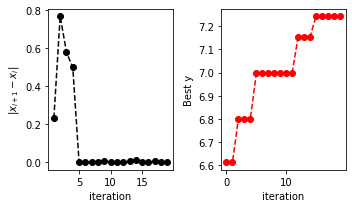

In [88]:
X_rec = X_sampled[n_init_samples:].flatten()
#Y_best = Y_max[n_init_samples:].flatten()

iters = np.arange(n_iters)
diff = np.abs(np.hstack((X_rec, np.array([0]))) - np.hstack((np.array([0]), X_rec)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 3))

ax1.plot(iters[1:], diff[1:-1], 'o', color='black')
ax1.plot(iters[1:], diff[1:-1], '--', color='black')
ax1.set_xlabel('iteration')
ax1.set_ylabel('$|x_{i+1} - x_{i}|$')

ax2.plot(iters, Y_max, 'o', color='red')
ax2.plot(iters, Y_max, '--', color='red')
ax2.set_xlabel('iteration')
ax2.set_ylabel('Best y')

plt.tight_layout()
plt.show()

In [39]:
a = np.array([2, 10, 15, 20, 22])
b = np.array([0])

c = np.hstack((b, a))
d = np.hstack((a, b))

print(c)
print(d)

[ 0  2 10 15 20 22]
[ 2 10 15 20 22  0]


In [40]:
(d - c)[1:-1]

array([8, 5, 5, 2])

In [97]:
minimize(lambda x: - objfunc(x), x0=[[7.5]], bounds=[[0, 10]])

      fun: array([-6.02063508])
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-17083363.9565663])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 42
      nit: 2
     njev: 21
   status: 0
  success: True
        x: array([7.49999929])